In [1]:
!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv

--2023-10-25 04:22:53--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1423529 (1.4M) [text/plain]
Saving to: ‘housing.csv’

housing.csv         100%[===================>]   1.36M  --.-KB/s    in 0.04s   

2023-10-25 04:22:54 (33.0 MB/s) - ‘housing.csv’ saved [1423529/1423529]



In [2]:
import pandas as pd
import numpy as np

In [3]:
data = pd.read_csv('housing.csv')

In [4]:
data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [5]:
data = data[(data.ocean_proximity == '<1H OCEAN') | (data.ocean_proximity == 'INLAND')].fillna(0)

In [6]:
data.median_house_value = np.log1p(data.median_house_value)

In [7]:
data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
701,-121.97,37.64,32.0,1283.0,194.0,485.0,171.0,6.0574,12.973866,<1H OCEAN
830,-121.99,37.61,9.0,3666.0,711.0,2341.0,703.0,4.6458,12.287657,<1H OCEAN
859,-121.97,37.57,21.0,4342.0,783.0,2172.0,789.0,4.6146,12.419574,<1H OCEAN
860,-121.96,37.58,15.0,3575.0,597.0,1777.0,559.0,5.7192,12.554971,<1H OCEAN
861,-121.98,37.58,20.0,4126.0,1031.0,2079.0,975.0,3.6832,12.287196,<1H OCEAN


In [15]:
from sklearn.model_selection import train_test_split

df_train_full, df_test = train_test_split(data,
                                          test_size = 0.2,
                                          random_state=1)
df_train, df_val = train_test_split(df_train_full,
                                    test_size=0.25,
                                    random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)


y_train_full = df_train_full.median_house_value
y_train = df_train.median_house_value
y_test = df_test.median_house_value
y_val = df_val.median_house_value

del df_train['median_house_value']
del df_test['median_house_value']
del df_val['median_house_value']


In [9]:
from sklearn.feature_extraction import DictVectorizer

dv = DictVectorizer(sparse=True)

train_dict = df_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dict)


test_dict = df_test.to_dict(orient='records')
X_test = dv.fit_transform(test_dict)


val_dict = df_val.to_dict(orient='records')
X_val = dv.fit_transform(val_dict)

In [10]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_auc_score
from sklearn.tree import export_text
dt = DecisionTreeRegressor(max_depth=1)
from sklearn.metrics import mean_squared_error
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

#Question 1

In [12]:
print(export_text(dt, feature_names=list(dv.get_feature_names_out())))

|--- ocean_proximity=<1H OCEAN <= 0.50
|   |--- value: [11.61]
|--- ocean_proximity=<1H OCEAN >  0.50
|   |--- value: [12.30]



In [13]:


clf = RandomForestRegressor(n_estimators=10,
                            random_state=1,
                           # n_jobs=-1
                            )

clf.fit(X_train, y_train)


RandomForestRegressor(n_estimators=10, random_state=1)

#Question 2

In [18]:


def rmse(y, y_pred):
    error = y_pred - y
    mse = (error ** 2).mean()
    return np.sqrt(mse)

y_pred_t = clf.predict(X_test)
print(mean_squared_error(y_test, y_pred_t))
print(rmse(y_test, y_pred_t))

y_pred_v = clf.predict(X_val)
print(mean_squared_error(y_val, y_pred_v))
print(rmse(y_val, y_pred_v))



0.052663953445734664
0.22948628160684173
0.06003095425651551
0.24501215124257716


#Question 3

In [22]:
scores = []
for n in range(10, 61, 10):
        print(n)
        rf = RandomForestRegressor(n_estimators=n,
                                    random_state=1)
        rf.fit(X_train, y_train)

        y_pred_v = rf.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred_v))

        scores.append((n, rmse))

columns = ['n_estimators', 'rmse']
df_scores = pd.DataFrame(scores, columns=columns)

10
20
30
40
50
60


In [23]:
df_scores

,n_estimators,rmse
0,10,0.245012
1,20,0.239098
2,30,0.236946
3,40,0.235247
4,50,0.235289
5,60,0.234992


#Question 4

In [26]:
scores1 = []
for m in [10, 15, 20, 25]:
  for n in range(10,201,10):
        print(m, ' ', n)
        rf = RandomForestRegressor(n_estimators=n,
                                    max_depth=m,
                                    random_state=1,
                                   n_jobs=-1)
        rf.fit(X_train, y_train)

        y_pred_v = rf.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred_v))

        scores.append((m, n, rmse))

10   10
10   20
10   30
10   40
10   50
10   60
10   70
10   80
10   90
10   100
10   110
10   120
10   130
10   140
10   150
10   160
10   170
10   180
10   190
10   200
15   10
15   20
15   30
15   40
15   50
15   60
15   70
15   80
15   90
15   100
15   110
15   120
15   130
15   140
15   150
15   160
15   170
15   180
15   190
15   200
20   10
20   20
20   30
20   40
20   50
20   60
20   70
20   80
20   90
20   100
20   110
20   120
20   130
20   140
20   150
20   160
20   170
20   180
20   190
20   200
25   10
25   20
25   30
25   40
25   50
25   60
25   70
25   80
25   90
25   100
25   110
25   120
25   130
25   140
25   150
25   160
25   170
25   180
25   190
25   200


,max_depth,n_estimators,rmse


In [29]:
columns1 = ['max_depth', 'n_estimators', 'rmse']
df_score1 = pd.DataFrame(scores, columns=columns1)

In [37]:
#df_score1
df_score1.groupby(by='rmse').mean()

,max_depth,n_estimators
rmse,,
0.233550,20.0,170.0
0.233575,20.0,160.0
0.233665,20.0,150.0
0.233707,20.0,180.0
0.233708,20.0,140.0
...,...,...
0.245854,10.0,80.0
0.246215,15.0,10.0
0.246649,10.0,30.0


#Question 5

In [16]:
rf = RandomForestRegressor(n_estimators=10,
                                    max_depth=20,
                                    random_state=1,
                                   n_jobs=-1)


rf.fit(X_train, y_train)

y_pred_v = rf.predict(X_val)
np.sqrt(mean_squared_error(y_val, y_pred_v))

0.24531287899896315

In [27]:
dv.get_feature_names_out()

array(['households', 'housing_median_age', 'latitude', 'longitude',
       'median_income', 'ocean_proximity=<1H OCEAN',
       'ocean_proximity=INLAND', 'population', 'total_bedrooms',
       'total_rooms'], dtype=object)

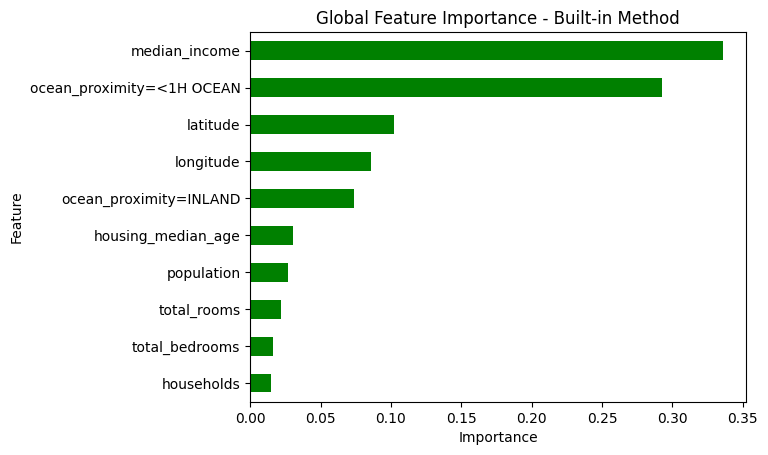

In [31]:
import matplotlib.pyplot as plt
global_importances = pd.Series(rf.feature_importances_, index=dv.get_feature_names_out())
global_importances.sort_values(ascending=True, inplace=True)
global_importances.plot.barh(color='green')
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Global Feature Importance - Built-in Method")
plt.show()

#Question 6

In [32]:
!pip install xgboost

In [12]:
import xgboost as xgb

In [21]:
dicts_full_train = df_train_full.to_dict(orient='records')

df_train_full = df_train_full.reset_index(drop=True)
#y_train_full = df_train_full.median_house_value
#del df_train_full['median_house_value']


dv = DictVectorizer(sparse=False)
X_full_train = dv.fit_transform(dicts_full_train)
y_pred_v =

dicts_test = df_test.to_dict(orient='records')
X_test = dv.transform(dicts_test)

In [23]:
xgb_params = {
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

features = dv.get_feature_names_out()
model = xgb.XGBRegressor(xgb_params = xgb_params)

model.fit(X_train, y_train)

y_pred_v = model.predict(X_val)

print('rmse: ', np.sqrt(mean_squared_error(y_val, y_pred_v)))

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [04:31:26] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb_params" } are not used.

  warnings.warn(smsg, UserWarning)


rmse:  0.228623199980106


In [24]:
xgb_params = {
    'eta': 0.1,
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

features = dv.get_feature_names_out()
model = xgb.XGBRegressor(xgb_params = xgb_params)

model.fit(X_train, y_train)

y_pred_v = model.predict(X_val)

print('rmse: ', np.sqrt(mean_squared_error(y_val, y_pred_v)))

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [04:31:27] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb_params" } are not used.

  warnings.warn(smsg, UserWarning)


rmse:  0.228623199980106
